In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, lasso_path, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
rng = np.random.default_rng(0)
n = 100
X = rng.normal(size=n)
eps = rng.normal(size=n)

In [29]:
X.shape

(100,)

(-50.0, 50.0)

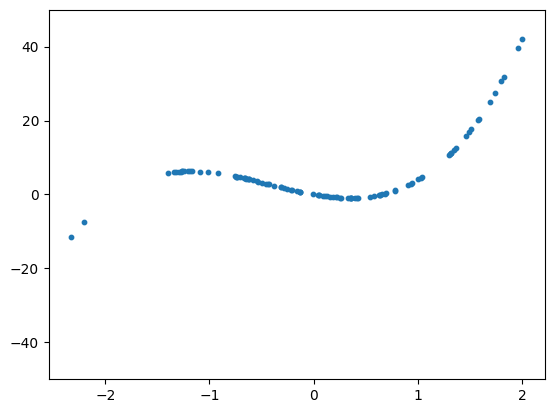

In [30]:
beta0, beta1, beta2, beta3 = 0, -5, 5, 4
Y = beta0 + beta1*X + beta2*X**2 + beta3*X**3# + eps
plt.scatter(X, Y, s=10)
plt.ylim([-50,50])

In [31]:
columns = [f'X^{i}' for i in range(1, 11)]
print(columns)

d = {name: col for name, col in zip(columns, [X**i for i in range(1, 11)])}
data = pd.DataFrame(d)
data['Y'] = Y
data.head()

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']


,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,0.125730,0.015808,0.001988,0.000250,0.000031,0.000004,4.966812e-07,6.244784e-08,7.851581e-09,9.871810e-10,-0.541660
1,-0.132105,0.017452,-0.002305,0.000305,-0.000040,0.000005,-7.021528e-07,9.275780e-08,-1.225376e-08,1.618781e-09,0.738561
2,0.640423,0.410141,0.262664,0.168216,0.107729,0.068992,4.418418e-02,2.829655e-02,1.812175e-02,1.160558e-02,-0.100753
3,0.104900,0.011004,0.001154,0.000121,0.000013,0.000001,1.397757e-07,1.466249e-08,1.538097e-09,1.613466e-10,-0.464863
4,-0.535669,0.286942,-0.153706,0.082336,-0.044105,0.023625,-1.265545e-02,6.779139e-03,-3.631377e-03,1.945217e-03,3.498232


Mallow's $C_p$ is defined as:

$$C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)$$

In [32]:
# Compute Cp
def nCp(sigma2, estimator, X, Y):
    "Cp statistic. The full model should yield p+1"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    #print('sigma2 | RSS:', sigma2, RSS)
    return (RSS + 2*p*sigma2)/n

In [33]:
# Fit model to data
def fit_model(model, X, y, sigma2):
    model_fitted = model.fit(X, y)

    Cp = nCp(sigma2, model_fitted, X, y)
    return Cp

In [34]:
# Compute sigma for the complete model
y = data['Y']

model = LinearRegression().fit(data[columns], y)
y_pred = model.predict(data[columns])
sigma2 = sum((y-y_pred)**2)/X.shape[0]

In [35]:
# Forward stepwise selection
current_columns = []
cp_values = []
for _ in range(len(columns)):
    best_cp = float('inf')
    best_col = ''
    for col in columns:
        if col not in current_columns:
            X = data[current_columns + [col]]
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp < best_cp:
                best_col = col
                best_cp = cp
            #print(cp)
    current_columns.append(best_col)
    print(current_columns)
    cp_values.append(best_cp)

print(current_columns)

['X^3']
['X^3', 'X^2']
['X^3', 'X^2', 'X^1']
['X^3', 'X^2', 'X^1', 'X^4']


['X^3', 'X^2', 'X^1', 'X^4', 'X^5']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7', 'X^6']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7', 'X^6', 'X^8']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7', 'X^6', 'X^8', 'X^9']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7', 'X^6', 'X^8', 'X^9', 'X^10']
['X^3', 'X^2', 'X^1', 'X^4', 'X^5', 'X^7', 'X^6', 'X^8', 'X^9', 'X^10']


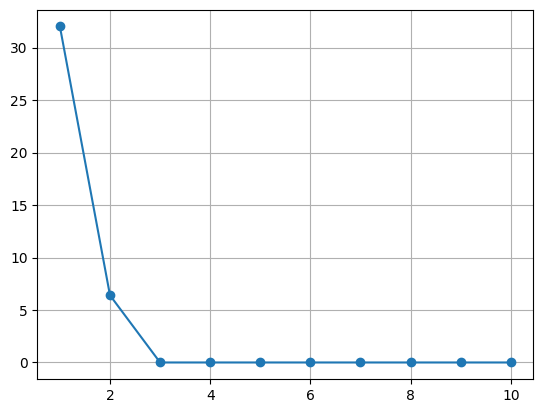

In [36]:
plt.plot(list(range(1, 11)), cp_values, marker='o')
plt.grid()

As we can see from the $C_p$ values obtained, and the plot, that we should choose only three predictors: $X_1$, $X_2$, $X_3$.

In [37]:
best_columns = ['X^1', 'X^2', 'X^3']
best_model = LinearRegression().fit(data[best_columns], y)
score = best_model.score(data[best_columns], y)
coefs = best_model.coef_
interc = best_model.intercept_
print(score, coefs, interc)

1.0 [-5.  5.  4.] 2.6645352591003757e-15


In [38]:
# Backwards stepwise selection
current_columns = columns[:] # Start with all columns
cp_values = []
for _ in range(len(columns)-1):
    print(current_columns)
    X = data[current_columns]
    best_cp = fit_model(LinearRegression(), X, y, sigma2)
    cp_values.append(best_cp)
    worst_col = ''
    for i, col in enumerate(columns):
        if col in current_columns:
            print('X:', current_columns[:i] + current_columns[i+1:])
            X = data[current_columns[:i] + current_columns[i+1:]] # All columns except index i
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp <= best_cp:
                worst_col = col
                best_cp = cp
            #print(cp)
    if worst_col == '':
        current_columns.pop(-1)
    else:
        current_columns.pop(current_columns.index(worst_col))
    #print(current_columns)
cp_values.append(best_cp)
print(current_columns)

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['

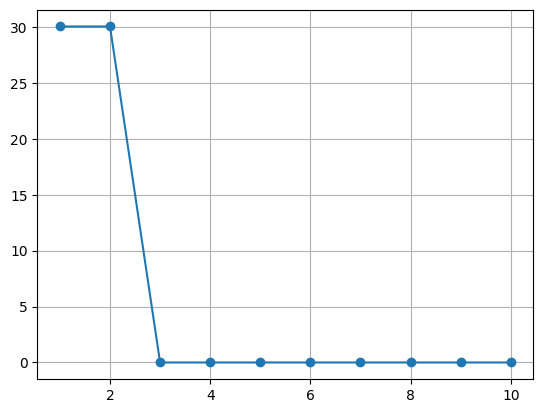

In [39]:
plt.plot(list(range(10, 0, -1)), cp_values, marker='o')
plt.grid()

In [40]:
X = data[columns]
y = data['Y']

K = 5
kfold = KFold(K, random_state=0, shuffle=True)

lassoCV = ElasticNetCV(
    n_alphas=200,
    l1_ratio=1,
    cv=kfold,
    eps=1e-8)
pipeCV = Pipeline(steps=[
    ('lasso', lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.0003155502599765843

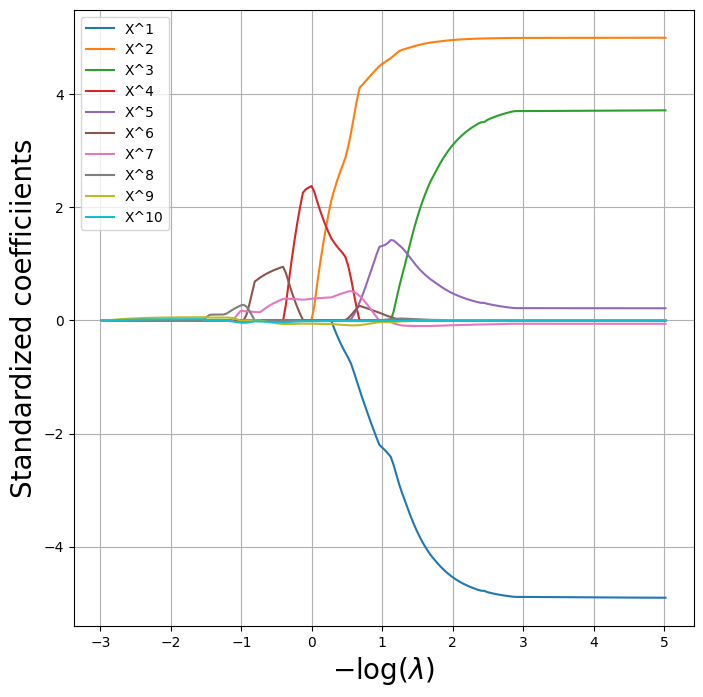

In [41]:
lambdas , soln_array = Lasso.path(
    X,
    Y,
    l1_ratio=1,
    n_alphas=200,
    eps=1e-8)[:2]
soln_path = pd.DataFrame(
    soln_array.T,
    columns=columns,
    index=-np.log10(lambdas))

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)
ax.grid()

In [42]:
tuned_lasso.alpha_

0.0003155502599765843

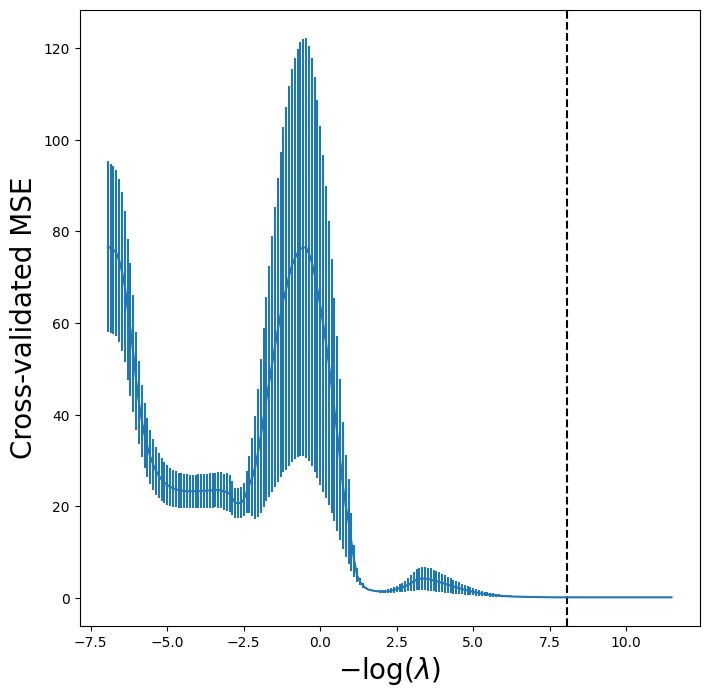

In [43]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [44]:
#min_idx = np.where(lambdas == round(tuned_lasso.alpha_, 0))
min_idx = np.where(lambdas == min(lambdas, key=lambda x: abs(x-tuned_lasso.alpha_)))
print(min_idx, lambdas[min_idx], -np.log(lambdas[min_idx]))
[a[min_idx] for a in soln_array]
tuned_lasso.coef_

(array([161], dtype=int64),) [0.00032179] [8.04162154]


array([-4.90055299e+00,  5.01052995e+00,  3.81283637e+00, -3.63428877e-02,
        7.75636620e-02,  1.69422885e-02, -3.34233357e-03, -7.06201816e-04,
       -1.44749694e-03, -4.31430824e-04])

In [45]:
-np.log(lambdas[min_idx])

array([8.04162154])

In [46]:
round(tuned_lasso.alpha_, 0), tuned_lasso.alpha_, lambdas

(0.0,
 0.0003155502599765843,
 array([9.54838558e+02, 8.70420164e+02, 7.93465299e+02, 7.23314104e+02,
        6.59365057e+02, 6.01069821e+02, 5.47928535e+02, 4.99485532e+02,
        4.55325432e+02, 4.15069578e+02, 3.78372791e+02, 3.44920410e+02,
        3.14425593e+02, 2.86626858e+02, 2.61285842e+02, 2.38185255e+02,
        2.17127018e+02, 1.97930564e+02, 1.80431292e+02, 1.64479150e+02,
        1.49937356e+02, 1.36681219e+02, 1.24597072e+02, 1.13581299e+02,
        1.03539444e+02, 9.43854004e+01, 8.60406768e+01, 7.84337199e+01,
        7.14993029e+01, 6.51779659e+01, 5.94155057e+01, 5.41625113e+01,
        4.93739403e+01, 4.50087325e+01, 4.10294578e+01, 3.74019954e+01,
        3.40952412e+01, 3.10808411e+01, 2.83329475e+01, 2.58279985e+01,
        2.35445149e+01, 2.14629168e+01, 1.95653552e+01, 1.78355593e+01,
        1.62586966e+01, 1.48212462e+01, 1.35108825e+01, 1.23163696e+01,
        1.12274649e+01, 1.02348316e+01, 9.32995818e+00, 8.50508566e+00,
        7.75314109e+00, 7.06767681

Repeat the problem with the following model:

$$Y = \beta_0 + \beta_7 X^7 + \epsilon$$

(-50.0, 50.0)

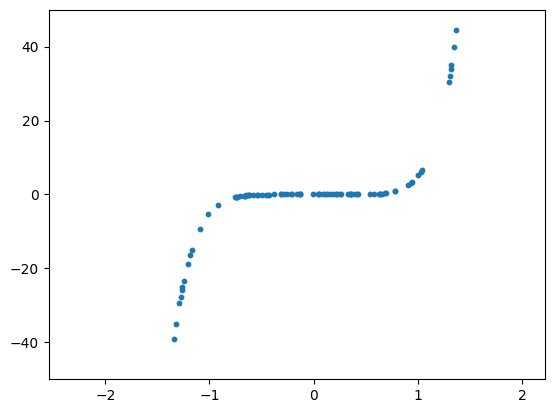

In [51]:
rng = np.random.default_rng(0)
n = 100
X = rng.normal(size=n)
eps = rng.normal(size=n)

beta0, beta7 = 0, 5
Y = beta0 + beta7*X**7# + eps
plt.scatter(X, Y, s=10)
plt.ylim([-50,50])

In [52]:
columns = [f'X^{i}' for i in range(1, 11)]
print(columns)

d = {name: col for name, col in zip(columns, [X**i for i in range(1, 11)])}
data = pd.DataFrame(d)
data['Y'] = Y
data.head()

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']


,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,0.125730,0.015808,0.001988,0.000250,0.000031,0.000004,4.966812e-07,6.244784e-08,7.851581e-09,9.871810e-10,2.483406e-06
1,-0.132105,0.017452,-0.002305,0.000305,-0.000040,0.000005,-7.021528e-07,9.275780e-08,-1.225376e-08,1.618781e-09,-3.510764e-06
2,0.640423,0.410141,0.262664,0.168216,0.107729,0.068992,4.418418e-02,2.829655e-02,1.812175e-02,1.160558e-02,2.209209e-01
3,0.104900,0.011004,0.001154,0.000121,0.000013,0.000001,1.397757e-07,1.466249e-08,1.538097e-09,1.613466e-10,6.988787e-07
4,-0.535669,0.286942,-0.153706,0.082336,-0.044105,0.023625,-1.265545e-02,6.779139e-03,-3.631377e-03,1.945217e-03,-6.327727e-02


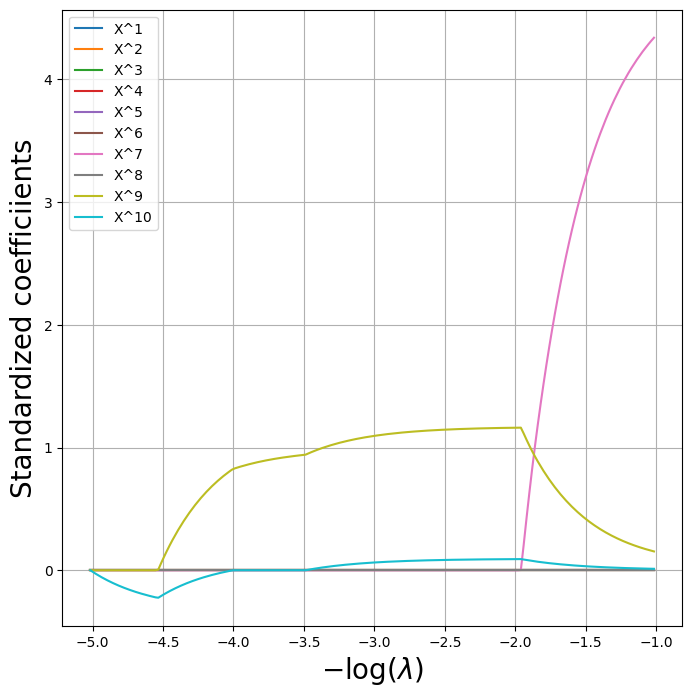

In [53]:
X = data[columns]
y = data['Y']

lambdas , soln_array = Lasso.path(
    X,
    y,
    l1_ratio=1,
    n_alphas=200,
    eps=1e-4)[:2]
soln_path = pd.DataFrame(
    soln_array.T,
    columns=columns,
    index=-np.log10(lambdas))

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)
ax.grid()

In [54]:
K = 5
kfold = KFold(K, random_state=0, shuffle=True)

lassoCV = ElasticNetCV(
    n_alphas=200,
    l1_ratio=1,
    cv=kfold,
    eps=1e-4)
pipeCV = Pipeline(steps=[
    ('lasso', lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_, tuned_lasso.coef_, tuned_lasso.coef_[6]

(10.3209805086877,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 4.33666906, 0.        , 0.15407299, 0.01194513]),
 4.33666905937465)